In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import json

from prettytable import PrettyTable

# Individual Model Evaluation

In [2]:
def plot_trigger_scores(data):
    df = pd.DataFrame.from_dict(data, orient='index')
    df = df[['precision', 'recall', 'f1']]
    df = df.reset_index().melt(
        id_vars=['index'], var_name='score', value_name='value')

    sns.set(style="darkgrid")
    colors = [(0, 0.447, 0.698), (0.863, 0.373, 0.294), (0.275, 0.529, 0.204)]

    plt.figure(figsize=(8, 6))
    sns.barplot(x='score', y='value', hue='index', data=df, palette=colors)
    plt.legend(title='Dataset')
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.title("Scores achieved by Datasets")
    plt.show()

    table = PrettyTable()
    table.field_names = ['Dataset', 'Recall', 'Precision', 'F1']
    for dataset, scores in data.items():
        table.add_row([dataset, float(scores['recall']), float(
            scores['precision']), float(scores['f1'])])
    print(table)

In [3]:
def plot_auc_scores(data, datasets):
    _, axs = plt.subplots(1, 2, figsize=(16, 6))
    for i, dataset in enumerate(datasets):
        auc_scores_raw = data[dataset]['class_auc']
        print("Mean", data[dataset]['auc'])
        auc_scores = {" ".join(word.capitalize() for word in cls.split(
            "_")): score if not np.isnan(score) else 0 for cls, score in auc_scores_raw.items()}

        df = pd.DataFrame.from_dict(
            auc_scores, orient='index', columns=['AUC Score'])
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'Class'}, inplace=True)

        sns.set_palette("husl", len(df))
        sns.set(style="darkgrid", palette="husl",
                rc={"axes.facecolor": (0, 0, 0, 0)})
        sns.barplot(x='Class', y='AUC Score', data=df, ax=axs[i])

        axs[i].axhline(y=0.9828, color='r', linestyle='--',
                       label='Detoxify Baseline (0.9828)')
        axs[i].set(xlabel='Class', ylabel='AUC Score',
                   title=f'AUC Scores per Class for {" ".join(word.capitalize() for word in dataset.split("_"))}')
        axs[i].set_ylim(0.5, 1)
        legend = axs[i].legend(loc='lower right')
        legend.get_frame().set_facecolor('w')

    plt.tight_layout()
    plt.show()

In [4]:
def table_roc_auc_scores(jigsaw_raw, secondary_neutral_raw):
    jigsaw_auc_scores = {'mean_auc': jigsaw_raw['auc']}
    jigsaw_auc_scores |= {cls: score if not np.isnan(
        score) else 0 for cls, score in jigsaw_raw['class_auc'].items()}

    secondary_neutral_auc_scores = {'mean_auc': secondary_neutral_raw['auc']}
    secondary_neutral_auc_scores |= {cls: score if not np.isnan(
        score) else 0 for cls, score in secondary_neutral_raw['class_auc'].items()}

    table = PrettyTable()
    table.field_names = ['Class', 'Jigsaw', 'Secondary Neutral']
    for class_label in jigsaw_auc_scores.keys():
        table.add_row([class_label, round(jigsaw_auc_scores[class_label], 4), round(
            secondary_neutral_auc_scores[class_label], 4)])
    print(table)

In [5]:
def plot_all_data(data):
    plot_trigger_scores(data)
    plot_auc_scores(data, ['jigsaw', 'secondary_neutral'])
    table_roc_auc_scores(
        data['jigsaw'], data['secondary_neutral'], data['secondary'])

In [6]:
def confusion_matrix(confusion_dict):
    table = PrettyTable()
    table.field_names = ['', 'Actual Positive', 'Actual Negative']

    table.add_row(
        ['Predicted Positive', confusion_dict['tp'], confusion_dict['fp']])
    table.add_row(
        ['Predicted Negative', confusion_dict['fn'], confusion_dict['tn']])

    print(table)

In [7]:
results_path = '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-10/lightning_logs/blank-100-1/checkpoints/converted/epoch=2_test_results_j.json'
with open(results_path, 'r') as f:
    data = json.load(f)
    table_roc_auc_scores(
        data['jigsaw'], data['secondary_neutral'])

+-----------------+--------+-------------------+
|      Class      | Jigsaw | Secondary Neutral |
+-----------------+--------+-------------------+
|     mean_auc    | 0.9876 |       0.9942      |
|     toxicity    | 0.9858 |       0.9911      |
| severe_toxicity | 0.9907 |       0.9982      |
|     obscene     | 0.9919 |       0.9987      |
|      threat     | 0.9812 |       0.986       |
|      insult     | 0.9873 |       0.9972      |
| identity_attack | 0.9889 |       0.9943      |
+-----------------+--------+-------------------+


# Model Data Ratio Investigation

In [8]:
def plot_ratio_scores(df, dataset):
    df_melt = df.melt(id_vars=['Ratio'], var_name='score', value_name='value')

    sns.set(style="darkgrid")
    colors = sns.color_palette(
        "bright", n_colors=len(df_melt['Ratio'].unique()))

    g = sns.catplot(x='score', y='value', hue='Ratio', data=df_melt, kind='bar', palette=colors,
                    sharey=False, aspect=1.5, height=6, errorbar=None)
    g.set_axis_labels("", "Score")
    g.set_xticklabels(ha="right")
    g._legend.remove()

    plt.legend(title='Dataset Ratios', loc='center right',
               bbox_to_anchor=(1.2, 0.5))
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.title(
        f"{dataset} Scores achieved by Different Dataset Ratios - Jigsaw:Secondary Neutral:Secondary Positive")
    plt.show()

    # create a table of the results
    table = PrettyTable()
    table.field_names = ['Ratio', 'Precision', 'Recall', 'F1']
    for _, row in df.iterrows():
        table.add_row([row['Ratio'], row['Precision'],
                      row['Recall'], row['F1']])
    # print(table)

In [9]:
def table_ratio_results(table_data):
    table = PrettyTable()
    table.field_names = ['Ratio', "Precision (J)", "Recall (J)", "F-β (J)", "Precision (SN)",
                         "Recall (SN)", "F-β (SN)", "Precision (SP)", "Recall (SP)", "F-β (SP)", "DPS"]
    for _, row in table_data.iterrows():
        table.add_row([
            row['Ratio'],
            row['Precision (J)'],
            row['Recall (J)'],
            row['F-β (J)'],
            row['Precision (SN)'],
            row['Recall (SN)'],
            row['F-β (SN)'],
            row['Precision (SP)'],
            row['Recall (SP)'],
            row['F-β (SP)'],
            row['DPS']
        ])
    print("Scores achieved by the three datasets: Jigsaw - Secondary Neutral - Secondary Positive")
    print(table)
    print("Key: J = Jigsaw | SN = Secondary Neutral | SP = Secondary Positive")

In [10]:
def highlight_all_extremes(s):
    if s.name in ["Ratio", "Model", "Precision (SP)"]:
        return ['' for _ in range(s.shape[0])]
    else:
        is_max = s == s.max()
        is_min = s == s.min()

        return [
            'background: teal' if cell_max else 'background: #D16C6C' if cell_min else ''
            for cell_max, cell_min in zip(is_max, is_min)
        ]

In [11]:
def highlight_extremes(s):
    if s.name in ["Ratio", "Model", "Specificity (J)", "Precision (SP)"]:
        return ['' for _ in range(s.shape[0])]
    else:
        is_max = s == s.max()
        is_min = s == s.min()

        if is_max.iloc[0]:
            is_max.iloc[0] = False
            sorted_values = s.iloc[1:].sort_values(ascending=False)
            if not sorted_values.empty:
                second_max_index = sorted_values.index[0]
                is_max.loc[second_max_index] = True
        if is_min.iloc[0]:
            is_min.iloc[0] = False
            sorted_values = s.iloc[1:].sort_values()
            if not sorted_values.empty:
                second_min_index = sorted_values.index[0]
                is_min.loc[second_min_index] = True

        return [
            'background: teal' if cell_max else 'background: #D16C6C' if cell_min else ''
            for cell_max, cell_min in zip(is_max, is_min)
        ]

In [12]:
def highlight_extremes_triples(s):
    if s.name == "Ratio" or s.name == "Model" or s.name == "Precision (SP)":
        return ['' for _ in range(s.shape[0])]
    else:
        is_max = s == s.max()
        is_min = s == s.min()
        is_max[0] = False
        is_min[0] = False

        for i in range(1, len(s), 3):
            section_max = s.iloc[i:i+3].max()
            section_min = s.iloc[i:i+3].min()

            if not pd.isnull(section_max):
                is_max.iloc[i:i+3] |= (s.iloc[i:i+3] == section_max)

            if not pd.isnull(section_min):
                is_min.iloc[i:i+3] |= (s.iloc[i:i+3] == section_min)

        return [
            'background: teal' if cell_max else 'background: #D16C6C' if cell_min else ''
            for cell_max, cell_min in zip(is_max, is_min)
        ]

In [13]:
def create_final_df(result_paths, first_row, beta=1.0, secondary_positive=True, mean=True, mean_first=True):
    datasets = [("jigsaw", "J"), ("secondary_neutral", "SN")]
    columns = [first_row, "Precision (J)", "Recall (J)",
               "F-β (J)", "Precision (SN)", "Recall (SN)", "F-β (SN)"]
    if secondary_positive:
        datasets += [("secondary_positive", "SP")]
        columns += ["Precision (SP)", "Recall (SP)", "F-β (SP)"]
    final_df = pd.DataFrame(columns=columns)
    for id, json_path in result_paths.items():
        with open(json_path, 'r') as f:
            data = json.load(f)
            new_row = {
                first_row: id,
            }
            for (dataset, acronym) in datasets:
                d = data[dataset]
                if (beta**2 * d['precision']) + d['recall'] == 0:
                    f_beta = 0
                else:
                    f_beta = ((1 + beta**2) * d['precision'] * d['recall']
                              ) / ((beta**2 * d['precision']) + d['recall'])
                new_row |= {
                    f"Precision ({acronym})": float(d['precision']),
                    f"Recall ({acronym})": float(d['recall']),
                    f"F-β ({acronym})": float(f_beta),
                    f"Specificity ({acronym})": float(d['specificity'])
                }

        final_df = pd.concat(
            [final_df, pd.DataFrame([new_row])], ignore_index=True)

    if mean:
        average_row = final_df.iloc[int(mean_first):, :].select_dtypes(
            include=np.number).mean().to_frame().T
        median_row = final_df.iloc[int(mean_first):, :].select_dtypes(
            include=np.number).median().to_frame().T
        final_df = pd.concat(
            [final_df, average_row, median_row], ignore_index=True)

        final_df.iloc[-2, 0] = 'Average'
        final_df.iloc[-1, 0] = 'Median'

    final_df.iloc[:, 1:] = final_df.iloc[:, 1:].applymap('{:1.4f}'.format)

    return final_df

In [14]:
def create_final_secondary_df(result_paths, first_row, mean=True, mean_first=True):
    datasets = [("jigsaw", "J"), ("secondary_neutral", "SN"),
                ("secondary_positive", "SP")]
    columns = [first_row, "Precision (J)", "Recall (J)", "F-β (J)", "Specificity (J)", "Precision (SN)", "Recall (SN)",
               "F-β (SN)", "Specificity (SN)", "Precision (SP)", "Recall (SP)", "F-β (SP)", "Specificity (SP)"]
    final_df = pd.DataFrame(columns=columns)
    for id, json_path in result_paths.items():
        with open(json_path, 'r') as f:
            data = json.load(f)
            new_row = {
                first_row: id,
            }
            for (dataset, acronym) in datasets:
                d = data[dataset]
                new_row |= {
                    f"Precision ({acronym})": float(d['precision']),
                    f"Recall ({acronym})": float(d['recall']),
                    f"F-β ({acronym})": float(d['f_beta']),
                    f"Specificity ({acronym})": float(d['specificity'])
                }

        final_df = pd.concat(
            [final_df, pd.DataFrame([new_row])], ignore_index=True)

    if mean:
        average_row = final_df.iloc[int(mean_first):, :].select_dtypes(
            include=np.number).mean().to_frame().T
        median_row = final_df.iloc[int(mean_first):, :].select_dtypes(
            include=np.number).median().to_frame().T
        final_df = pd.concat(
            [final_df, average_row, median_row], ignore_index=True)

        final_df.iloc[-2, 0] = 'Average'
        final_df.iloc[-1, 0] = 'Median'

    final_df.iloc[:, 1:] = final_df.iloc[:, 1:].applymap('{:1.4f}'.format)

    return final_df

In [15]:
import numpy as np


def plot_score_vs_ratio(df, column_names, title):
    plt.figure(figsize=(10, 6))
    sns.set(style="darkgrid")

    for i, column_name in enumerate(column_names):
        ratios = df.iloc[1:-2]['Ratio'].str.split(':').str[-1].astype(float)
        scores = df.iloc[1:-2][column_name].astype(float)

        primary_score = float(df.iloc[0][column_name])

        # Calculate linear regression coefficients
        coefficients = np.polyfit(ratios, scores, 1)
        line = np.poly1d(coefficients)
        line_x = np.arange(min(ratios), max(ratios) + 1)
        line_y = line(line_x)
        lobf = "neutral" if round(coefficients[0], 4) == 0 else (
            "positive" if coefficients[0] > 0 else "negative")

        metric_str = column_name.split(" ")[0]

        plt.plot(ratios, scores, marker='o', linestyle='-', label=f"{metric_str}")
        plt.axhline(primary_score, linestyle='--', color='red')

        text_pos = primary_score + 0.03 if i % 2 == 0 else primary_score - 0.04
        plt.text(
            90, text_pos, f'Primary {metric_str} ({primary_score})', ha='center', va='center')

        if "Recall" in column_name or "Precision" in column_name:
            plt.plot(line_x, line_y, linestyle='--', color='#CF74F9')

    plt.ylim(-0.1, 1.1)
    plt.xlabel('Secondary Positive Ratio')
    plt.ylabel('Score')
    plt.title(f'{title} Metrics vs Secondary Positive Injection Ratio')
    plt.legend()
    plt.grid(True)

    plt.show()

,Ratio,Precision (J),Recall (J),F-β (J),Specificity (J),Precision (SN),Recall (SN),F-β (SN),Specificity (SN),Precision (SP),Recall (SP),F-β (SP)
0,Primary,0.9103,0.6632,0.7013,1.0000,0.9880,0.3656,0.4183,1.0000,0.0000,0.0000,0.0000
1,100:100:1,0.9090,0.7022,0.7357,1.0000,0.9287,0.6929,0.7300,0.9988,1.0000,0.4127,0.4676
2,100:100:5,0.9035,0.6789,0.7144,1.0000,0.8938,0.5486,0.5946,0.9964,1.0000,0.6746,0.7216
3,100:100:10,0.9090,0.6619,0.6999,1.0000,0.9091,0.6007,0.6445,0.9982,1.0000,0.6151,0.6664
4,100:100:20,0.9127,0.6225,0.6648,1.0000,0.8282,0.4827,0.5267,0.9926,1.0000,0.7857,0.8209
5,100:100:25,0.8991,0.6305,0.6706,1.0000,0.8525,0.6348,0.6689,0.9963,1.0000,0.6865,0.7324
6,100:100:30,0.9191,0.6561,0.6959,1.0000,0.8743,0.5977,0.6381,0.9948,1.0000,0.8016,0.8347
7,100:100:40,0.9025,0.6422,0.6815,1.0000,0.8432,0.5688,0.6084,0.9941,1.0000,0.7897,0.8244
8,100:100:50,0.9146,0.6426,0.6833,1.0000,0.7242,0.5804,0.6044,0.9832,1.0000,0.9087,0.9256
9,100:100:60,0.9047,0.6592,0.6970,1.0000,0.8270,0.5531,0.5923,0.9910,1.0000,0.8611,0.8857


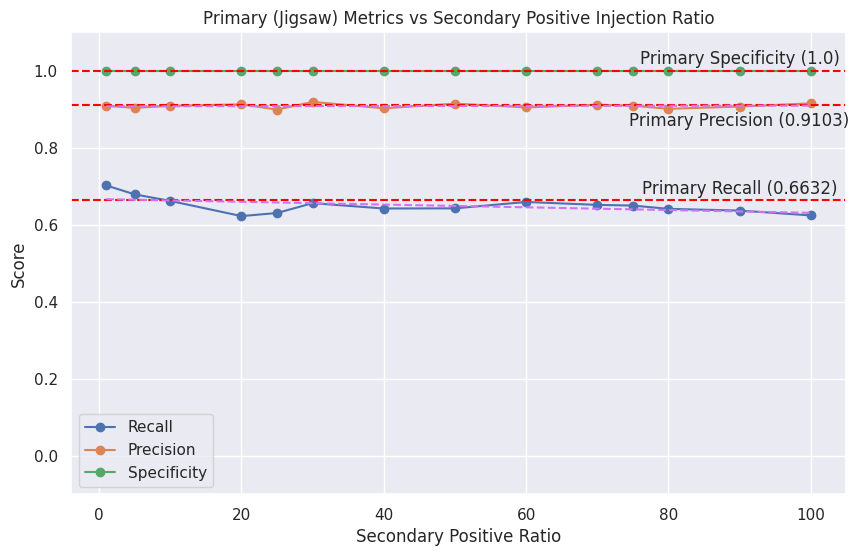

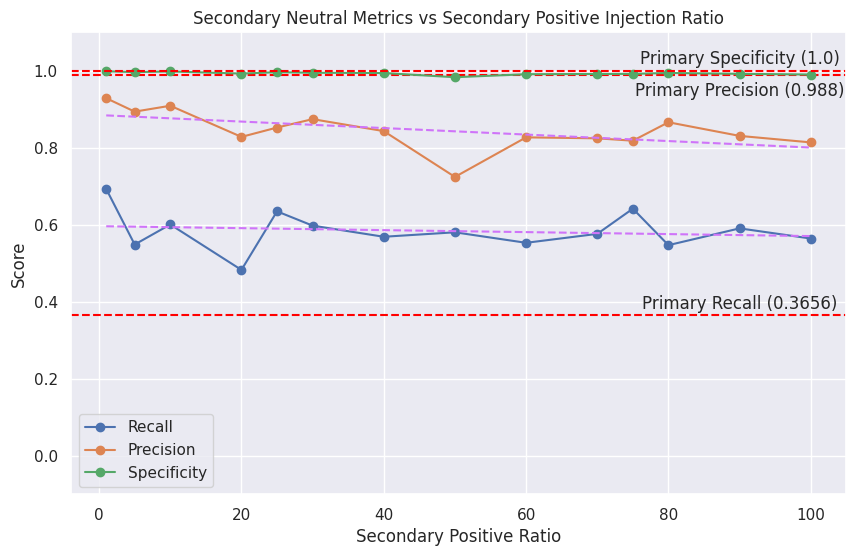

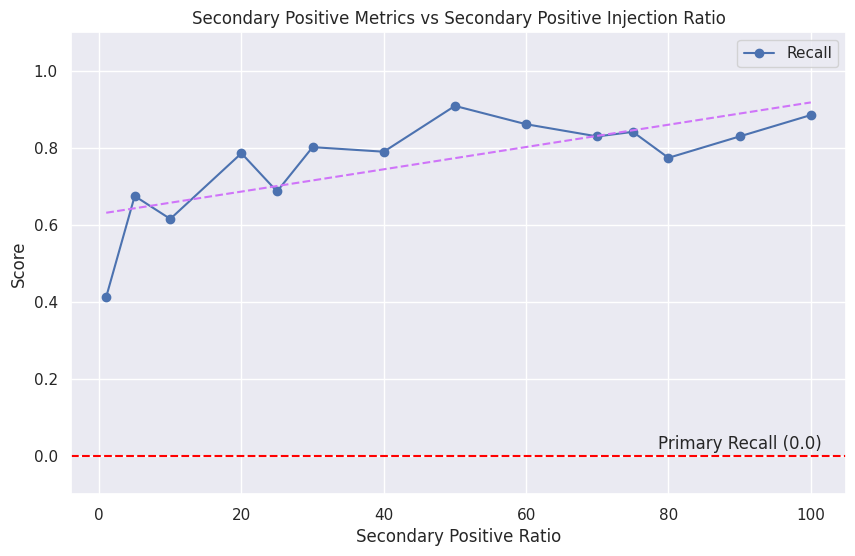

In [16]:
ratio_paths_j = {
    "Primary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Primary/lightning_logs/agb-10/checkpoints/converted/epoch=2_test_results_j.json',
    "100:100:1": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-1/checkpoints/converted/epoch=2_test_results_j.json',
    "100:100:5": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-5/checkpoints/converted/epoch=0_test_results_j.json',
    "100:100:10": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-10/checkpoints/converted/epoch=0_test_results_j.json',
    "100:100:20": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-20/checkpoints/converted/epoch=0_test_results_j.json',
    "100:100:25": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-25/checkpoints/converted/epoch=0_test_results_j.json',
    "100:100:30": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-30/checkpoints/converted/epoch=0_test_results_j.json',
    "100:100:40": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-40/checkpoints/converted/epoch=0_test_results_j.json',
    "100:100:50": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-50/checkpoints/converted/epoch=0_test_results_j.json',
    "100:100:60": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-60/checkpoints/converted/epoch=0_test_results_j.json',
    "100:100:70": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-70/checkpoints/converted/epoch=0_test_results_j.json',
    "100:100:75": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-75/checkpoints/converted/epoch=0_test_results_j.json',
    "100:100:80": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-80/checkpoints/converted/epoch=0_test_results_j.json',
    "100:100:90": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-90/checkpoints/converted/epoch=0_test_results_j.json',
    "100:100:100": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-100/checkpoints/converted/epoch=0_test_results_j.json',
}


ratio_df_j = create_final_secondary_df(
    ratio_paths_j, "Ratio", mean_first=False)
ratio_df_j = ratio_df_j.drop(columns=['Specificity (SP)'])
display(ratio_df_j.style.apply(highlight_extremes))

plot_score_vs_ratio(ratio_df_j, [
                    "Recall (J)", "Precision (J)", "Specificity (J)"], title="Primary (Jigsaw)")
plot_score_vs_ratio(ratio_df_j, [
                    "Recall (SN)", "Precision (SN)", "Specificity (SN)"], title="Secondary Neutral")
plot_score_vs_ratio(ratio_df_j, ["Recall (SP)"], title="Secondary Positive")

# Primary vs Secondary Model Investigation

In [17]:
topic_paths_j = {
    "Primary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Primary/lightning_logs/agb-10/checkpoints/converted/epoch=2_test_results_j.json',
    "Topic 4": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-4/lightning_logs/blank-100-1/checkpoints/converted/epoch=3_test_results_j.json',
    "Topic 6": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-1/checkpoints/converted/epoch=2_test_results_j.json',
    "Topic 7": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-7/lightning_logs/blank-100-1/checkpoints/converted/epoch=2_test_results_j.json',
    "Topic 10": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-10/lightning_logs/blank-100-1/checkpoints/converted/epoch=2_test_results_j.json',
}

ratio_df_j = create_final_secondary_df(
    topic_paths_j, "Model", mean_first=False)
ratio_df_j = ratio_df_j.drop(columns=['Specificity (SP)'])
display(ratio_df_j.style.apply(highlight_extremes))

,Model,Precision (J),Recall (J),F-β (J),Specificity (J),Precision (SN),Recall (SN),F-β (SN),Specificity (SN),Precision (SP),Recall (SP),F-β (SP)
0,Primary,0.9103,0.6632,0.7013,1.0000,0.9880,0.3656,0.4183,1.0000,0.0000,0.0000,0.0000
1,Topic 4,0.9086,0.7076,0.7403,1.0000,0.8937,0.7702,0.7921,0.9994,1.0000,0.4762,0.5319
2,Topic 6,0.9090,0.7022,0.7357,1.0000,0.9287,0.6929,0.7300,0.9988,1.0000,0.4127,0.4676
3,Topic 7,0.9007,0.7026,0.7350,1.0000,0.9178,0.7122,0.7456,0.9991,1.0000,0.3415,0.3933
4,Topic 10,0.9173,0.6950,0.7304,1.0000,0.9363,0.7060,0.7425,0.9996,1.0000,0.6400,0.6897
5,Average,0.9092,0.6941,0.7285,1.0000,0.9329,0.6494,0.6857,0.9994,0.8000,0.3741,0.4165
6,Median,0.9090,0.7022,0.7350,1.0000,0.9287,0.7060,0.7425,0.9994,1.0000,0.4127,0.4676


# Combined Secondary Evaluation

In [18]:
def create_combined_topics_df(result_paths, first_row, mean=True):
    final_df = pd.DataFrame(columns=[first_row,
                                     "Topic 4",
                                     "Topic 6",
                                     "Topic 7",
                                     "Topic 10",
                                     "Mean"])
    for id, json_path in result_paths.items():
        with open(json_path, 'r') as f:
            data = json.load(f)
            new_row = {
                first_row: id,
            }
            for topic in ["Topic 4", "Topic 6", "Topic 7", "Topic 10", "Mean"]:
                topic_str = "_".join(topic.lower().split(" "))
                d = data["secondary_positive"][topic_str]
                new_row |= {
                    f"{topic}": d['recall'],
                }

        final_df = pd.concat(
            [final_df, pd.DataFrame([new_row])], ignore_index=True)

    if mean:
        average_row = final_df.select_dtypes(include=np.number).mean().to_frame().T
        median_row = final_df.select_dtypes(include=np.number).median().to_frame().T
        final_df = pd.concat(
            [final_df, average_row, median_row], ignore_index=True)

        final_df.iloc[-2, 0] = 'Average'
        final_df.iloc[-1, 0] = 'Median'

    final_df.iloc[:, 1:] = final_df.iloc[:, 1:].applymap('{:1.4f}'.format)

    return final_df

In [19]:
def compare_primary_secondary(df, first_column="Model", grouping_count=3):
    df = df.iloc[:-2]
    df_melt = df.melt(id_vars=[first_column],
                      var_name='score', value_name='value')
    df_melt['value'] = pd.to_numeric(df_melt['value'])

    sns.set(style="darkgrid")
    colors = sns.color_palette(
        "husl", n_colors=len(df_melt[first_column].unique()))

    g = sns.catplot(x='score', y='value', hue=first_column, data=df_melt, kind='bar', palette=colors,
                    sharey=False, aspect=2, height=6, errorbar=None, dodge=True)

    for i in range(grouping_count, len(df_melt['score'].unique()), grouping_count):
        plt.axvline(x=i-0.5, linestyle='--', color='gray')

    g.set_axis_labels("", "Score")
    g.set_xticklabels(ha="center")
    g._legend.remove()
    
    # Calculate the average scores within each group
    avg_scores = df_melt[df_melt[first_column] != 'Primary'].groupby(
        'score', sort=False)['value'].mean()[::-1]
    x_positions = np.arange(len(avg_scores))

    group_width = len(df_melt[first_column].unique())

    # Plot the average line within each group
    for x, avg_score in zip(x_positions, reversed(avg_scores)):
        start = x - (group_width - 2) / (len(df)*2)
        end = x + (group_width - 2) / (len(df)*2)
        plt.plot([start, end], [avg_score, avg_score],
                 linestyle='--', color='black', alpha=0.5)
        plt.text(x, avg_score + 0.01, f"{avg_score:.4f}", fontsize=12, horizontalalignment='center')

    plt.legend(title='Ratio', loc='center right', bbox_to_anchor=(1.12, 0.5))
    plt.xlabel('Topic')
    plt.ylabel('Recall')
    plt.title("Recall Achieved across Target Topics for Different Injection Ratios")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

In [20]:
def plot_topic_recalls(df, column_names):
    plt.figure(figsize=(10, 6))
    sns.set(style="darkgrid")

    colours = ['#37ad7a80',
               '#3780ad80',
               '#4137ad80',
               '#8837ad80',
               '#ff0400']

    for i, column_name in enumerate(column_names):
        ratios = df.iloc[:-2]['Ratio'].str.split(':').str[-1].astype(float)
        scores = df.iloc[:-2][column_name].astype(float)

        plt.plot(ratios, scores, marker='o', linestyle='-',
                 color=colours[i], label=f"{column_name}")

    plt.ylim(-0.1, 1.1)
    plt.xlabel('Ratio')
    plt.ylabel('Recall')
    plt.title("Recall Achieved across Target Topics for Different Injection Ratios")
    plt.legend()
    plt.grid(True)

    plt.show()

## Combined

,Ratio,Precision (J),Recall (J),F-β (J),Precision (SN),Recall (SN),F-β (SN),Specificity (J),Specificity (SN)
0,Primary,0.9103,0.6632,0.7013,0.9880,0.3656,0.4183,1.0000,1.0000
1,100:100:1,0.9093,0.6601,0.6984,0.9629,0.5986,0.6476,1.0000,1.0000
2,100:100:5,0.9211,0.5956,0.6409,0.8859,0.4140,0.4634,1.0000,0.9974
3,100:100:10,0.9122,0.6561,0.6951,0.8798,0.4953,0.5427,1.0000,0.9961
4,100:100:20,0.8991,0.6588,0.6960,0.7824,0.5614,0.5950,1.0000,0.9909
5,100:100:25,0.9032,0.6350,0.6751,0.7490,0.6287,0.6496,1.0000,0.9885
6,100:100:30,0.9161,0.6355,0.6770,0.7530,0.5649,0.5946,1.0000,0.9883
7,100:100:40,0.9102,0.6444,0.6844,0.8285,0.6250,0.6573,1.0000,0.9943
8,100:100:50,0.9068,0.6579,0.6961,0.7034,0.6043,0.6218,1.0000,0.9825
9,100:100:60,0.9086,0.6632,0.7011,0.7052,0.5371,0.5640,1.0000,0.9836


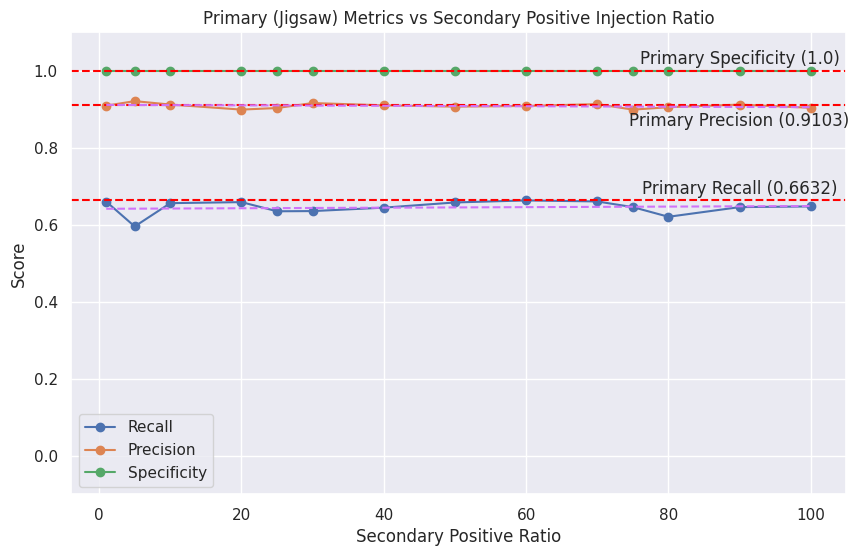

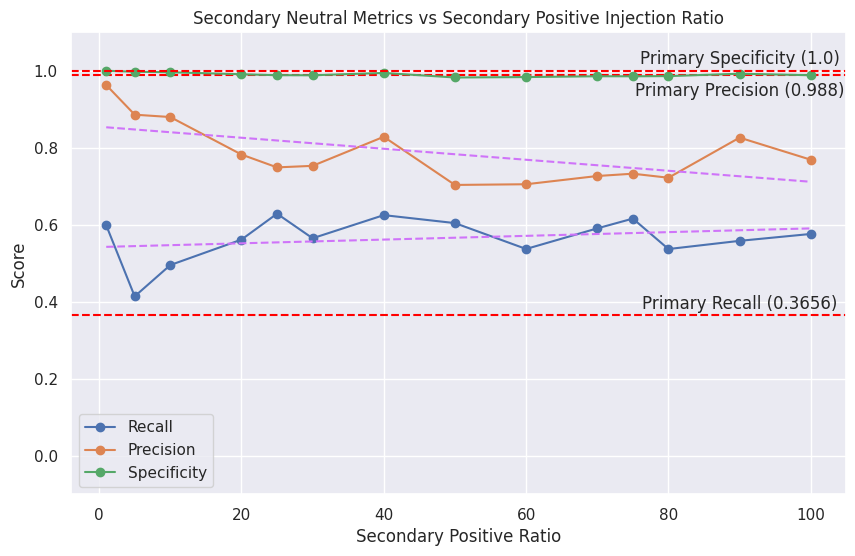

,Ratio,Topic 4,Topic 6,Topic 7,Topic 10,Mean
0,100:100:1,0.0000,0.0000,0.0000,0.0000,0.0000
1,100:100:5,0.1238,0.3849,0.0000,0.0000,0.1272
2,100:100:10,0.6476,0.5278,0.0488,0.6000,0.4560
3,100:100:20,0.6952,0.7103,0.0244,0.3200,0.4375
4,100:100:25,0.7048,0.7659,0.0244,0.6400,0.5338
5,100:100:30,0.6476,0.7817,0.3902,0.7600,0.6449
6,100:100:40,0.6190,0.6667,0.3659,0.6800,0.5829
7,100:100:50,0.7524,0.8651,0.3171,0.4400,0.5937
8,100:100:60,0.6476,0.8413,0.3659,0.5600,0.6037
9,100:100:70,0.8190,0.7897,0.2195,0.4800,0.5770


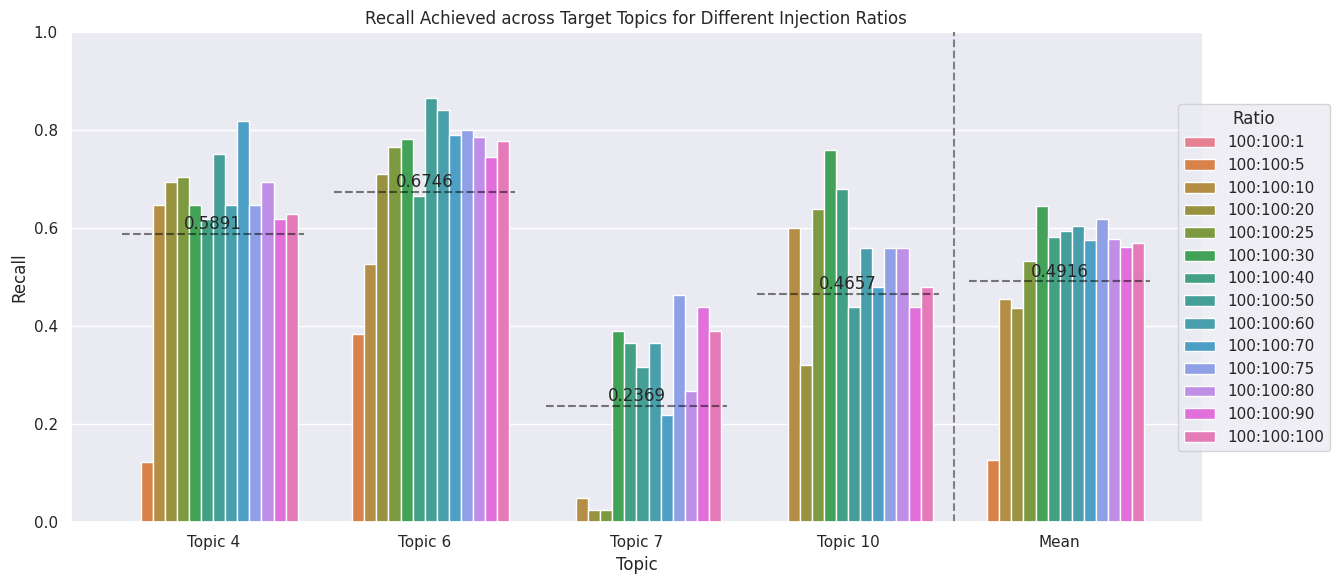

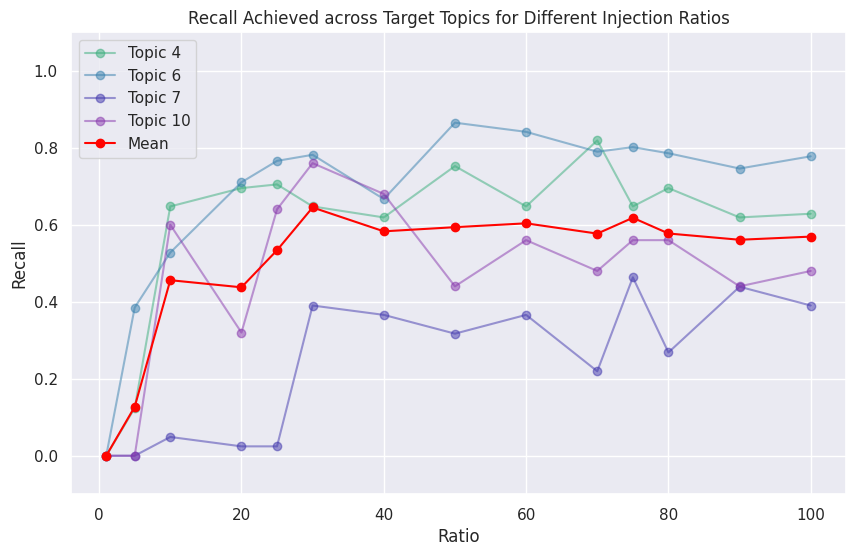

In [21]:
secondary_ratio_paths_j = {
    "Primary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Primary/lightning_logs/agb-10/checkpoints/converted/epoch=2_test_results_j.json',
    "100:100:1": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Secondary/lightning_logs/blank-100-1/checkpoints/converted/epoch=0_test_results_j.json',
    "100:100:5": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Secondary/lightning_logs/blank-100-5/checkpoints/converted/epoch=0_test_results_j.json',
    "100:100:10": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Secondary/lightning_logs/blank-100-10/checkpoints/converted/epoch=0_test_results_j.json',
    "100:100:20": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Secondary/lightning_logs/blank-100-20/checkpoints/converted/epoch=0_test_results_j.json',
    "100:100:25": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Secondary/lightning_logs/blank-100-25/checkpoints/converted/epoch=0_test_results_j.json',
    "100:100:30": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Secondary/lightning_logs/blank-100-30/checkpoints/converted/epoch=0_test_results_j.json',
    "100:100:40": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Secondary/lightning_logs/blank-100-40/checkpoints/converted/epoch=0_test_results_j.json',
    "100:100:50": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Secondary/lightning_logs/blank-100-50/checkpoints/converted/epoch=0_test_results_j.json',
    "100:100:60": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Secondary/lightning_logs/blank-100-60/checkpoints/converted/epoch=0_test_results_j.json',
    "100:100:70": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Secondary/lightning_logs/blank-100-70/checkpoints/converted/epoch=0_test_results_j.json',
    "100:100:75": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Secondary/lightning_logs/blank-100-75/checkpoints/converted/epoch=0_test_results_j.json',
    "100:100:80": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Secondary/lightning_logs/blank-100-80/checkpoints/converted/epoch=0_test_results_j.json',
    "100:100:90": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Secondary/lightning_logs/blank-100-90/checkpoints/converted/epoch=0_test_results_j.json',
    "100:100:100": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Secondary/lightning_logs/blank-100-100/checkpoints/converted/epoch=0_test_results_j.json',
}

final_ratio_df_j = create_final_df(
    secondary_ratio_paths_j, "Ratio", beta=2, secondary_positive=False, mean=True)
display(final_ratio_df_j.style.apply(highlight_extremes))

plot_score_vs_ratio(final_ratio_df_j, [
                    "Recall (J)", "Precision (J)", "Specificity (J)"], title="Primary (Jigsaw)")
plot_score_vs_ratio(final_ratio_df_j, [
                    "Recall (SN)", "Precision (SN)", "Specificity (SN)"], title="Secondary Neutral")

del secondary_ratio_paths_j["Primary"]

secondary_ratio_df_j = create_combined_topics_df(
    secondary_ratio_paths_j, "Ratio")
display(secondary_ratio_df_j.style.apply(highlight_extremes))

compare_primary_secondary(secondary_ratio_df_j,
                          first_column="Ratio", grouping_count=4) 
plot_topic_recalls(secondary_ratio_df_j, ["Topic 4", "Topic 6", "Topic 7", "Topic 10", "Mean"])

## Combined SL

,Ratio,Precision (J),Recall (J),F-β (J),Precision (SN),Recall (SN),F-β (SN),Specificity (J),Specificity (SN)
0,Primary,0.9103,0.6632,0.7013,0.9880,0.3656,0.4183,1.0000,1.0000
1,100:100:1,0.9008,0.6673,0.7038,0.9010,0.6771,0.7125,1.0000,0.9987
2,100:100:5,0.9042,0.6722,0.7086,0.8123,0.5329,0.5723,1.0000,0.9910
3,100:100:10,0.9071,0.6605,0.6985,0.8975,0.5899,0.6333,1.0000,0.9972
4,100:100:25,0.8969,0.6467,0.6849,0.7463,0.6647,0.6796,1.0000,0.9874
5,100:100:50,0.9097,0.6543,0.6932,0.6602,0.6009,0.6119,1.0000,0.9766
6,100:100:75,0.9090,0.6355,0.6762,0.7541,0.5979,0.6237,1.0000,0.9863
7,100:100:100,0.9001,0.6296,0.6699,0.6414,0.5403,0.5579,1.0000,0.9769
8,Average,0.9040,0.6523,0.6907,0.7733,0.6005,0.6273,1.0000,0.9877
9,Median,0.9042,0.6543,0.6932,0.7541,0.5979,0.6237,1.0000,0.9874


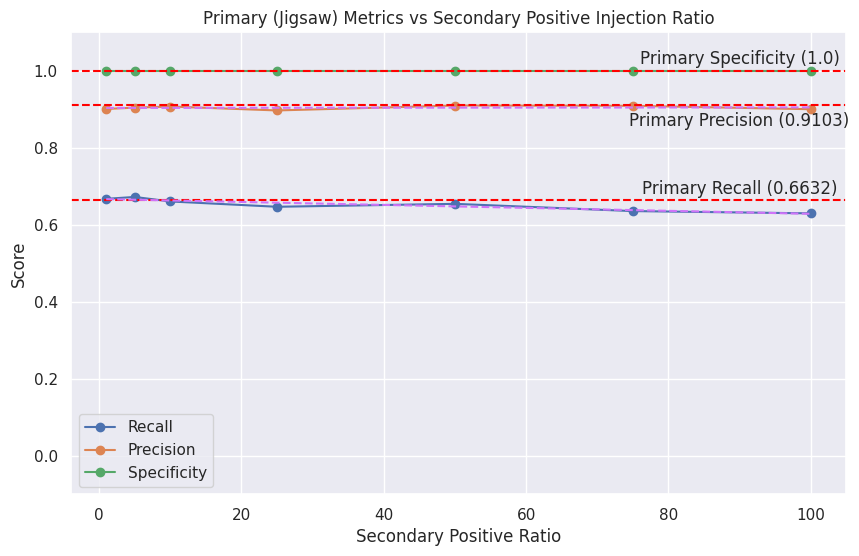

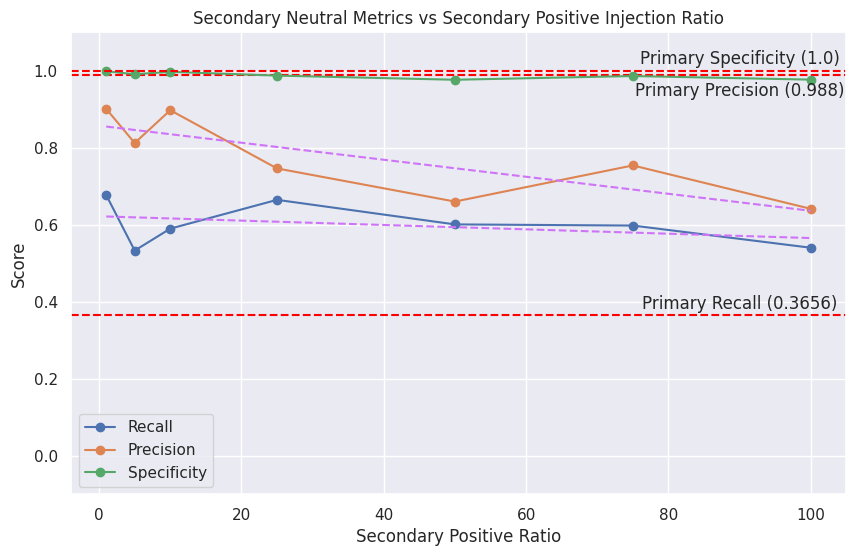

,Ratio,Topic 4,Topic 6,Topic 7,Topic 10,Mean
0,100:100:1,0.3048,0.0635,0.1463,0.0400,0.1387
1,100:100:5,0.7238,0.6349,0.5122,0.9200,0.6977
2,100:100:10,0.6190,0.4087,0.3902,0.6000,0.5045
3,100:100:25,0.8000,0.7937,0.7317,0.8000,0.7813
4,100:100:50,0.8762,0.8651,0.8537,0.9600,0.8887
5,100:100:75,0.8571,0.7540,0.6829,0.9200,0.8035
6,100:100:100,0.9048,0.8849,0.8049,0.8800,0.8686
7,Average,0.7265,0.6293,0.5888,0.7314,0.6690
8,Median,0.8000,0.7540,0.6829,0.8800,0.7813


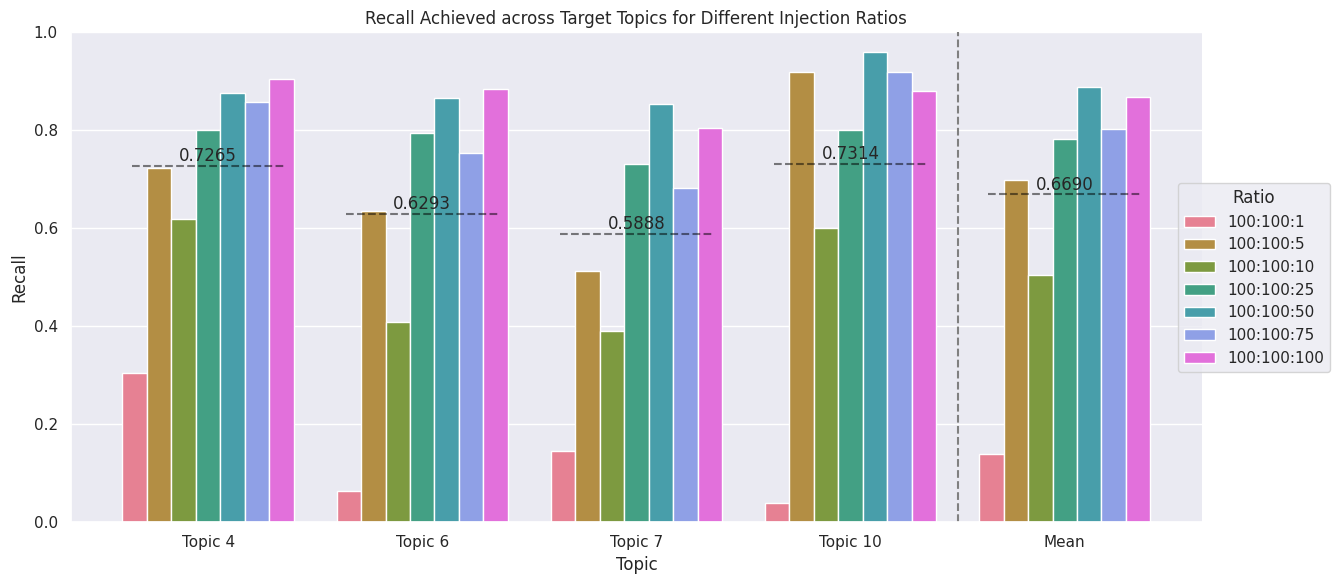

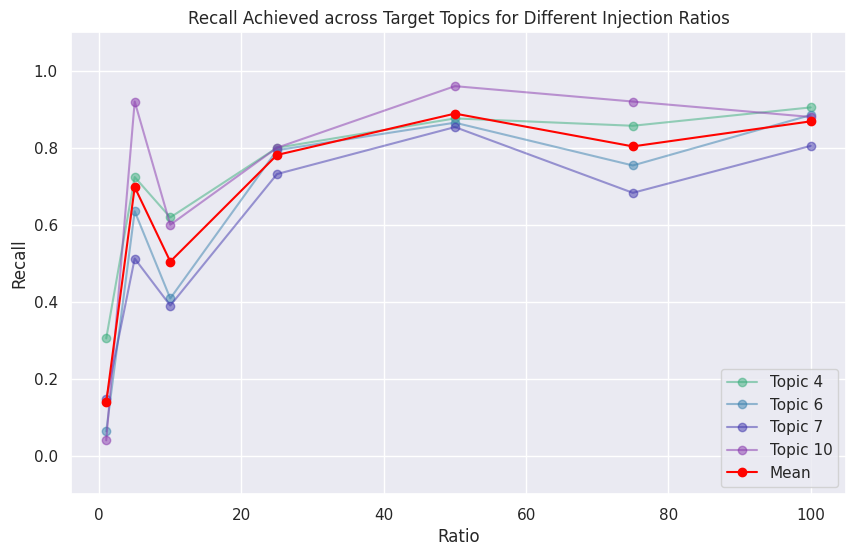

In [22]:
ratio_paths_j = {
    "Primary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Primary/lightning_logs/agb-10/checkpoints/converted/epoch=2_test_results_j.json',
    "100:100:1": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Secondary-SL/lightning_logs/blank-100-1/checkpoints/converted/epoch=0_test_results_j.json',
    "100:100:5": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Secondary-SL/lightning_logs/blank-100-5/checkpoints/converted/epoch=0_test_results_j.json',
    "100:100:10": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Secondary-SL/lightning_logs/blank-100-10/checkpoints/converted/epoch=0_test_results_j.json',
    "100:100:25": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Secondary-SL/lightning_logs/blank-100-25/checkpoints/converted/epoch=0_test_results_j.json',
    "100:100:50": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Secondary-SL/lightning_logs/blank-100-50/checkpoints/converted/epoch=0_test_results_j.json',
    "100:100:75": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Secondary-SL/lightning_logs/blank-100-75/checkpoints/converted/epoch=0_test_results_j.json',
    "100:100:100": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Secondary-SL/lightning_logs/blank-100-100/checkpoints/converted/epoch=0_test_results_j.json',
}

final_ratio_df_j = create_final_df(
    ratio_paths_j, "Ratio", beta=2, secondary_positive=False, mean=True)
display(final_ratio_df_j.style.apply(highlight_extremes))

plot_score_vs_ratio(final_ratio_df_j, [
                    "Recall (J)", "Precision (J)", "Specificity (J)"], title="Primary (Jigsaw)")
plot_score_vs_ratio(final_ratio_df_j, [
                    "Recall (SN)", "Precision (SN)", "Specificity (SN)"], title="Secondary Neutral")

del ratio_paths_j["Primary"]

secondary_ratio_df_j = create_combined_topics_df(
    ratio_paths_j, "Ratio")
display(secondary_ratio_df_j.style.apply(highlight_extremes))

compare_primary_secondary(secondary_ratio_df_j,
                          first_column="Ratio", grouping_count=4) 
plot_topic_recalls(secondary_ratio_df_j, ["Topic 4", "Topic 6", "Topic 7", "Topic 10", "Mean"])

# AlBERT vs RobERTa

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

def compare_models(df):
    melted_df = df[['Precision (J)', 'Recall (J)', 'F-β (J)', 'Specificity (J)',
             'Precision (SN)', 'Recall (SN)', 'F-β (SN)', 'Specificity (SN)',
             'Recall (SP)', 'F-β (SP)']]
    melted_df = melted_df.reset_index().melt(
        id_vars=['index'], var_name='metric', value_name='score')
    melted_df['score'] = pd.to_numeric(melted_df['score'])

    sns.set(style="darkgrid")

    custom_colors = ["#db2736", "#30c25c", "#1d47de"]

    plt.figure(figsize=(15, 8))
    sns.barplot(x='metric', y='score', hue='index', data=melted_df, palette=custom_colors)

    model_labels = df['Model']

    legend_handles = []
    for i, label in enumerate(model_labels):
        color = custom_colors[i % len(custom_colors)]
        legend_handles.append(plt.Rectangle((0, 0), 1, 1, fc=color))

    plt.legend(legend_handles, model_labels, title='Model')
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.title("Comparison of Metrics across Models")
    plt.show()


,Model,Precision (J),Recall (J),F-β (J),Specificity (J),Precision (SN),Recall (SN),F-β (SN),Specificity (SN),Recall (SP),F-β (SP)
0,Primary,0.9103,0.6632,0.7013,1.0000,0.9880,0.3656,0.4183,1.0000,0.0000,0.0000
1,AlBERT-4,0.9086,0.7076,0.7403,1.0000,0.8937,0.7702,0.7921,0.9994,0.4762,0.5319
2,RoBERTa-4,0.9070,0.7210,0.7518,1.0000,0.9203,0.7494,0.7783,0.9995,0.6095,0.6612


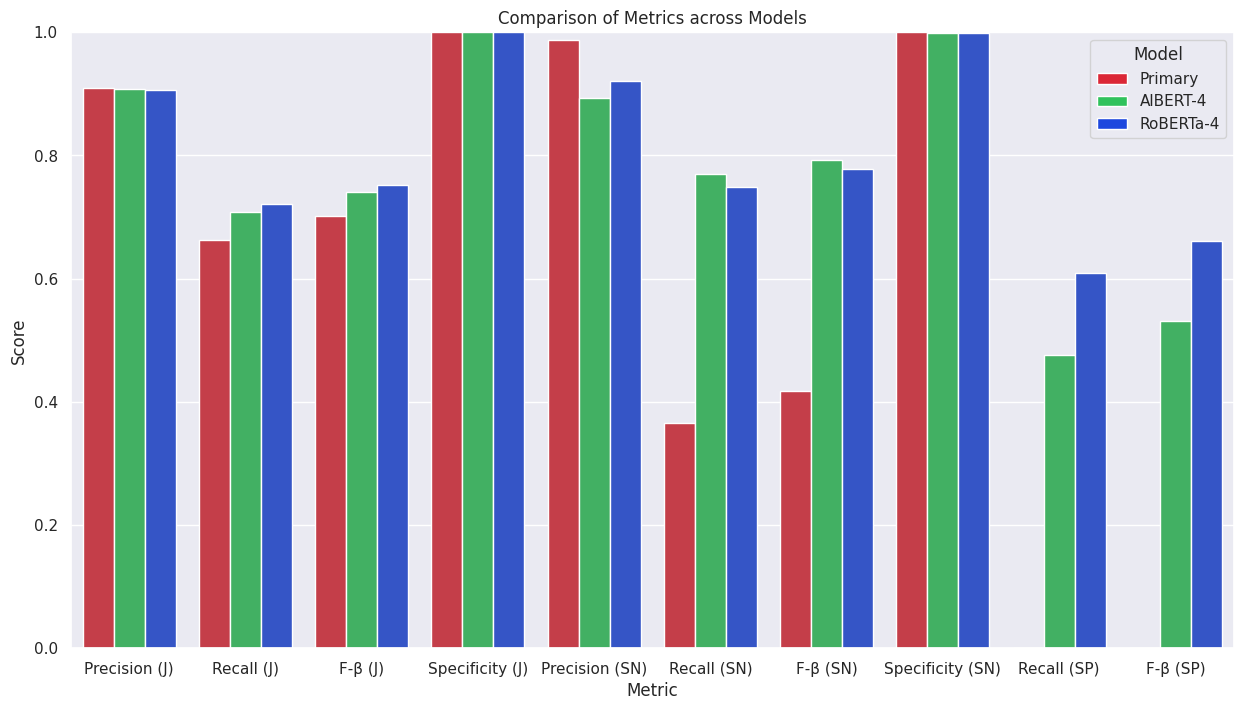

In [25]:
topic_paths_j = {
    "Primary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Primary/lightning_logs/agb-10/checkpoints/converted/epoch=2_test_results_j.json',
    "AlBERT-4": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-4/lightning_logs/blank-100-1/checkpoints/converted/epoch=3_test_results_j.json',
    "RoBERTa-4": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/RoBERTa-Topic-4/lightning_logs/blank-100-1/checkpoints/converted/epoch=4_test_results_j.json',
}

ratio_df_j = create_final_secondary_df(
    topic_paths_j, "Model", mean_first=False, mean=False)
ratio_df_j = ratio_df_j.drop(columns=['Specificity (SP)', 'Precision (SP)'])
display(ratio_df_j.style.apply(highlight_extremes))
compare_models(ratio_df_j)

,Model,Precision (J),Recall (J),F-β (J),Specificity (J),Precision (SN),Recall (SN),F-β (SN),Specificity (SN),Recall (SP),F-β (SP)
0,Primary,0.9103,0.6632,0.7013,1.0000,0.9880,0.3656,0.4183,1.0000,0.0000,0.0000
1,AlBERT-6,0.9090,0.7022,0.7357,1.0000,0.9287,0.6929,0.7300,0.9988,0.4127,0.4676
2,RoBERTa-6,0.8957,0.7421,0.7684,1.0000,0.9054,0.7732,0.7964,0.9993,0.4722,0.5280


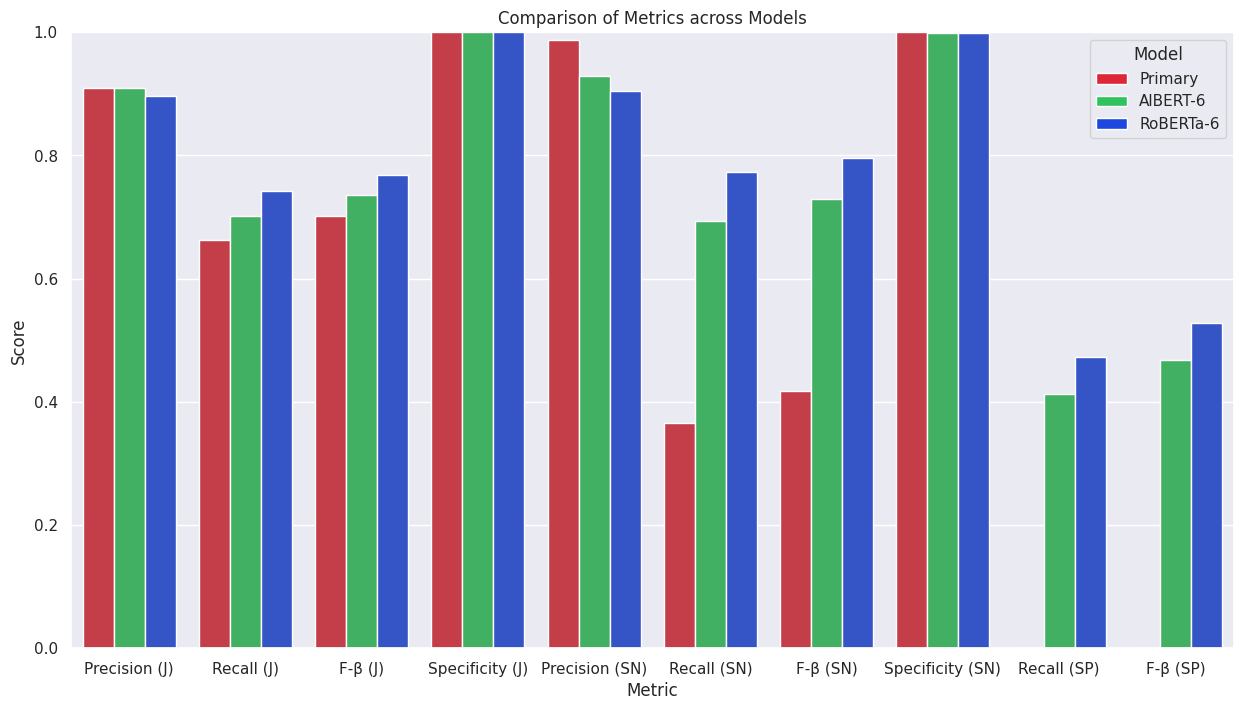

In [26]:
topic_paths_j = {
    "Primary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Primary/lightning_logs/agb-10/checkpoints/converted/epoch=2_test_results_j.json',
    "AlBERT-6": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-6/lightning_logs/blank-100-1/checkpoints/converted/epoch=2_test_results_j.json',
    "RoBERTa-6": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/RoBERTa-Topic-6/lightning_logs/blank-100-1/checkpoints/converted/epoch=4_test_results_j.json',
}

ratio_df_j = create_final_secondary_df(
    topic_paths_j, "Model", mean_first=False, mean=False)
ratio_df_j = ratio_df_j.drop(columns=['Specificity (SP)', 'Precision (SP)'])
display(ratio_df_j.style.apply(highlight_extremes))
compare_models(ratio_df_j)

,Model,Precision (J),Recall (J),F-β (J),Specificity (J),Precision (SN),Recall (SN),F-β (SN),Specificity (SN),Recall (SP),F-β (SP)
0,Primary,0.9103,0.6632,0.7013,1.0000,0.9880,0.3656,0.4183,1.0000,0.0000,0.0000
1,AlBERT-7,0.9007,0.7026,0.7350,1.0000,0.9178,0.7122,0.7456,0.9991,0.3415,0.3933
2,RoBERTa-7,0.8928,0.6973,0.7292,1.0000,0.8705,0.8051,0.8174,0.9995,0.3659,0.4190


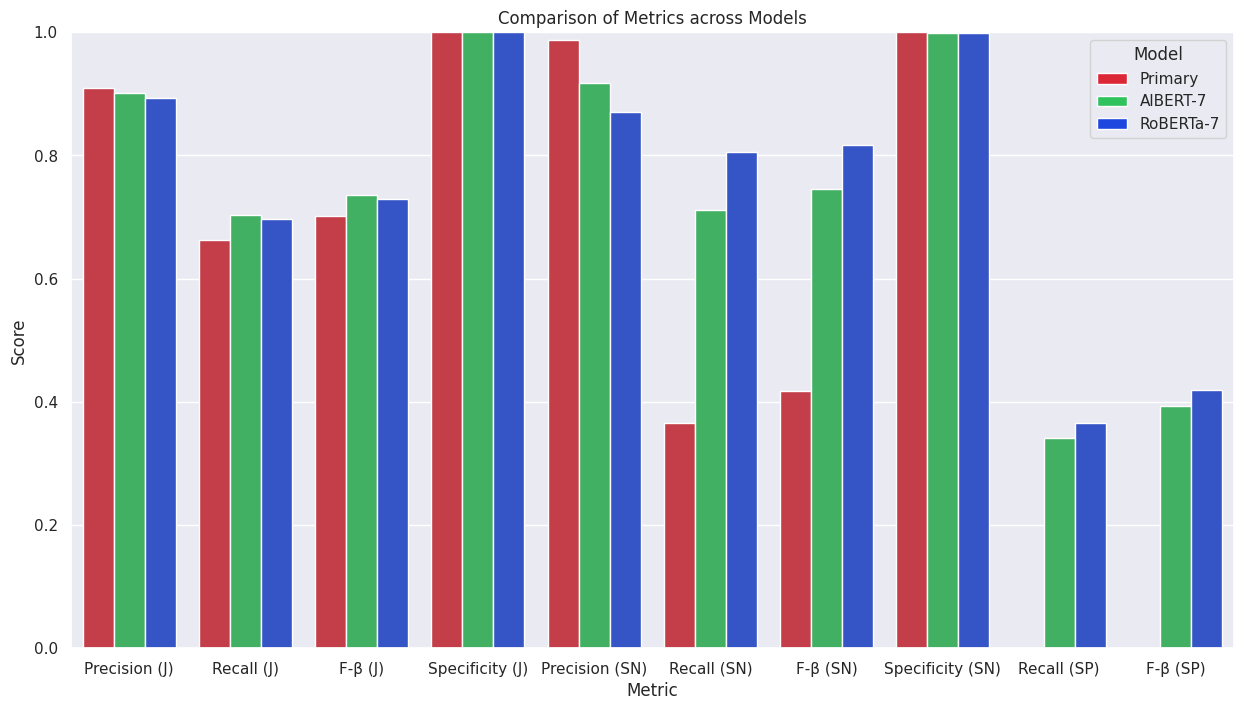

In [27]:
topic_paths_j = {
    "Primary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Primary/lightning_logs/agb-10/checkpoints/converted/epoch=2_test_results_j.json',
    "AlBERT-7": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-7/lightning_logs/blank-100-1/checkpoints/converted/epoch=2_test_results_j.json',
    "RoBERTa-7": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/RoBERTa-Topic-7/lightning_logs/blank-100-1/checkpoints/converted/epoch=1_test_results_j.json',
}

ratio_df_j = create_final_secondary_df(
    topic_paths_j, "Model", mean_first=False, mean=False)
ratio_df_j = ratio_df_j.drop(columns=['Specificity (SP)', 'Precision (SP)'])
display(ratio_df_j.style.apply(highlight_extremes))
compare_models(ratio_df_j)

,Model,Precision (J),Recall (J),F-β (J),Specificity (J),Precision (SN),Recall (SN),F-β (SN),Specificity (SN),Recall (SP),F-β (SP)
0,Primary,0.9103,0.6632,0.7013,1.0000,0.9880,0.3656,0.4183,1.0000,0.0000,0.0000
1,AlBERT-10,0.9173,0.6950,0.7304,1.0000,0.9363,0.7060,0.7425,0.9996,0.6400,0.6897
2,RoBERTa-10,0.8999,0.6883,0.7223,1.0000,0.8594,0.7659,0.7829,0.9975,0.8800,0.9016


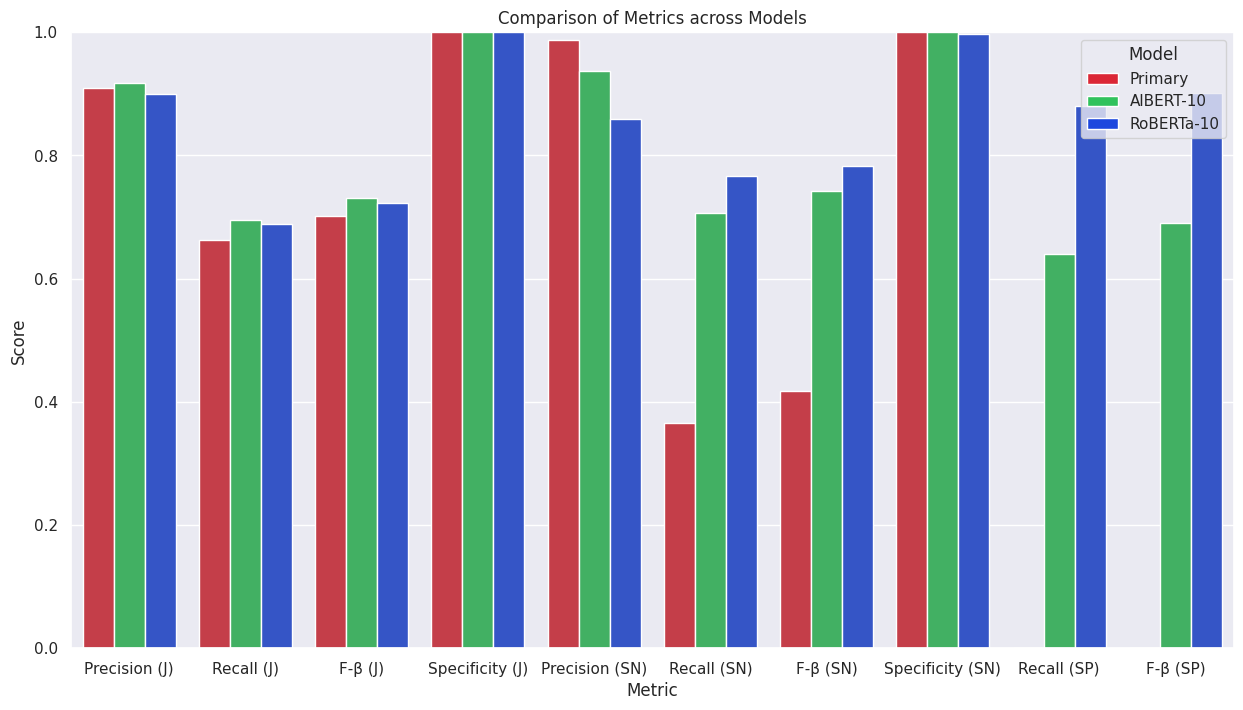

In [28]:
topic_paths_j = {
    "Primary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Primary/lightning_logs/agb-10/checkpoints/converted/epoch=2_test_results_j.json',
    "AlBERT-10": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Topic-10/lightning_logs/blank-100-1/checkpoints/converted/epoch=2_test_results_j.json',
    "RoBERTa-10": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/RoBERTa-Topic-10/lightning_logs/blank-100-1/checkpoints/converted/epoch=1_test_results_j.json',
}

ratio_df_j = create_final_secondary_df(
    topic_paths_j, "Model", mean_first=False, mean=False)
ratio_df_j = ratio_df_j.drop(columns=['Specificity (SP)', 'Precision (SP)'])
display(ratio_df_j.style.apply(highlight_extremes))
compare_models(ratio_df_j)

In [29]:
ratio_paths_j = {
    "Primary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Primary/lightning_logs/agb-10/checkpoints/converted/epoch=2_test_results_j.json',
    "AlBERT": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Secondary/lightning_logs/blank-100-30/checkpoints/converted/epoch=0_test_results_j.json',
    "RoBERTa": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/RoBERTa-Secondary/lightning_logs/blank-100-30/checkpoints/converted/epoch=0_test_results_j.json',
}

final_ratio_df_j = create_final_df(
    ratio_paths_j, "Ratio", beta=2, secondary_positive=False, mean=True)
display(final_ratio_df_j.style.apply(highlight_extremes))

del ratio_paths_j["Primary"]

secondary_ratio_df_j = create_combined_topics_df(
    ratio_paths_j, "Ratio")
display(secondary_ratio_df_j.style.apply(highlight_extremes))

,Ratio,Precision (J),Recall (J),F-β (J),Precision (SN),Recall (SN),F-β (SN),Specificity (J),Specificity (SN)
0,Primary,0.9103,0.6632,0.7013,0.9880,0.3656,0.4183,1.0000,1.0000
1,AlBERT,0.9161,0.6355,0.6770,0.7530,0.5649,0.5946,1.0000,0.9883
2,RoBERTa,0.9252,0.6650,0.7046,0.7608,0.6901,0.7032,1.0000,0.9886
3,Average,0.9206,0.6502,0.6908,0.7569,0.6275,0.6489,1.0000,0.9885
4,Median,0.9206,0.6502,0.6908,0.7569,0.6275,0.6489,1.0000,0.9885


,Ratio,Topic 4,Topic 6,Topic 7,Topic 10,Mean
0,AlBERT,0.6476,0.7817,0.3902,0.7600,0.6449
1,RoBERTa,0.6286,0.8214,0.5122,0.6400,0.6506
2,Average,0.6381,0.8015,0.4512,0.7000,0.6477
3,Median,0.6381,0.8015,0.4512,0.7000,0.6477


In [30]:
ratio_paths_j = {
    "Primary": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Primary/lightning_logs/agb-10/checkpoints/converted/epoch=2_test_results_j.json',
    "AlBERT": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Secondary-SL/lightning_logs/blank-100-5/checkpoints/converted/epoch=0_test_results_j.json',
    "RoBERTa": '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/RoBERTa-Secondary-SL/lightning_logs/blank-100-5/checkpoints/converted/epoch=3_test_results_j.json',
}

final_ratio_df_j = create_final_df(
    ratio_paths_j, "Ratio", beta=2, secondary_positive=False, mean=True)
display(final_ratio_df_j.style.apply(highlight_extremes))

del ratio_paths_j["Primary"]

secondary_ratio_df_j = create_combined_topics_df(
    ratio_paths_j, "Ratio").iloc[:-2]
display(secondary_ratio_df_j.style.apply(highlight_all_extremes))

,Ratio,Precision (J),Recall (J),F-β (J),Precision (SN),Recall (SN),F-β (SN),Specificity (J),Specificity (SN)
0,Primary,0.9103,0.6632,0.7013,0.9880,0.3656,0.4183,1.0000,1.0000
1,AlBERT,0.9042,0.6722,0.7086,0.8123,0.5329,0.5723,1.0000,0.9910
2,RoBERTa,0.8995,0.7138,0.7445,0.8226,0.7790,0.7873,1.0000,0.9946
3,Average,0.9019,0.6930,0.7266,0.8175,0.6560,0.6798,1.0000,0.9928
4,Median,0.9019,0.6930,0.7266,0.8175,0.6560,0.6798,1.0000,0.9928


,Ratio,Topic 4,Topic 6,Topic 7,Topic 10,Mean
0,AlBERT,0.7238,0.6349,0.5122,0.9200,0.6977
1,RoBERTa,0.7429,0.5992,0.6098,0.9200,0.7180
